In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# GBM

Done:
- import BSCall function [DONE]
- add delta to CallBS [DONE]
- simulate stock price as GBM[DONE]
- calculate option price with Black-Scholes through path [DONE]
- implement classical delta hedging without transaction costs [DONE] [NOT USED]
- implement option written on many underlying shares [DONE]
- APL (trading by delta hedging -> holding by delta hedging -> add trading costs -> APL) [DONE]
- calculate outstanding trading cots C [DONE]
- calculate objective function Y [DONE]
- make random simulation choice [DONE]
- solve for stochastic volatility process [DONE]
- generate correlated random normal numbers for the two Brownian Motions [DONE]
- implement SABR simulation [DONE]
- add description to CallBS [DONE]
- make all of the above into functions with description [DONE]
- run simulation of 1 and 3 months [DONE]
- create implementation function [DONE]
- figure our the proper way of putting T and dt for 3 months [DONE]
- figure out where mu is used (in asset price simulation) [DONE]
- implement practitioner delta (same as BS delta, just fancy name in SABR) [DONE]
- calculate implied volatility  [DONE]
- add Black-Scholes vega to call option pricer [DONE]
- implement Bartlett's delta [DONE]

To do:
- plot all processes nicely (title, legend, etc.)
- check working


In [39]:
# PARAMETERS

T = 60 # length of simulation 20=1 month, 60 = three months
S0 = 100 # starting price
K = 100 # strike price
sigma = 0.2 # volatility
r = 0 # risk-free rate
q = 0 # dividend yield
mu = 0.05 # expected return on stock
kappa = 0.01 # trading cost per unit traded
dt = 1
notional = 1 # how many stocks the option is on
rho = -0.4
v = 0.6
sigma0 = 0.2
prob = 0.5
c = 1.5
ds = 0.01
n = 100000
days = 250
freq = 1
np.random.seed(100)

## Simulation

In [40]:
def CallBS(t, T, K, S, r, q, sigma): #[DONE]
    '''
    Calculates the price and the delta of a call option using the Black-Scholes formula.
    Inputs:
        t = current time
        T = expiry time
        K = strike price
        S = current stock price
        r = risk-free rate
        q = dividend yield
        sigma = volatility
    Outputs:
        P = option price
        delta = option delta
    '''
    d1 = (np.log(S/K) + (r -q + 0.5*sigma**2)*(T-t)) / (sigma* np.sqrt(T-t))
    d2 = d1 - (sigma* np.sqrt(T-t))
    
    # price
    P = S * np.exp(-q*(T-t))* norm.cdf(d1) - np.exp(-r*(T-t)) * K * norm.cdf(d2) 
    
    # delta
    delta = np.exp(-q*(T-t))*norm.cdf(d1)

    # vega not used
    # vega (for calculating bartlett's delta)
    #vega = S*np.exp(-r*(T-t)*np.sqrt(T-t)*norm.pdf(d1))

    return P, delta#, vega

In [41]:
def GBM_sim(n, T, dt, S0, mu, r, q, sigma, days, freq): #[DONE]
    '''
    Simulates the price of the underlying with a geometric brownian motion model (Black-Scholes model), from time 0 to final time T.
    Calculates the option price and delta at all time steps using the Black-Scholes option pricing formula.
    Inputs:
        n =     [float] number of paths
        T =     [float] time to expiry
        dt =    [float] time step, function of frequency (e.g. freq*0.01)
        S0 =    [float] current (starting) price
        mu =    [float] return on asset
        r =     [float] risk-free rate
        q =     [float] dividend yield
        sigma = [float] volatility
        days =  [int] number of days in year
        freq =  [float] trading frequency (e.g. 2 = every two days, 0.5 = every day twice)
    Output:
        S =     [array] simulated underlying price process
        p =     [array] derived option price process
        delta = [array] derived option delta process
    '''
    # initialise variables
    S = np.zeros((n, T))  # Underlying price path
    p = np.zeros((n, T)) # Option price path
    delta = np.zeros((n, T)) # Option delta path

    S[:, 0] = S0
    p[:, 0], delta[:, 0] = CallBS(0, T, K, S[:, 0], r, q, sigma)

    T = int(T/freq) # adjust T to frequency
    
    # generate price path based on random component and derive option price and delta   
    for t in tqdm(range(1, T)):  # generate paths
        dW = np.random.normal(0, 1, size=(n,1)) # standard normal random variable

        S[:, t] = S[t-1]*np.exp((mu - 0.5*sigma**2)*dt/days + sigma*np.sqrt(dt/days)*dW) # BS Model of Stock Price 

        p[:, t], delta[:, t] = CallBS(t, T, K, S[:, t], r, q, sigma)

    sigma_stoch = np.nan # not used in this model but return it so that the output of GBM and SABR are of the same format
    bartlett_delta = np.nan # not used in this model but return it so that the output of GBM and SABR are of the same format
    
    return S, p, delta, sigma_stoch, bartlett_delta

In [42]:
def sabr_imp_vol(S, K, t, T, r, q, v, sigma_stoch, rho):
    # calculate implied sabr volatility for bartlett's delta (using formulat B.71b, B.71c in Hagan and Lesniewski (2002))
    # This is for our special case of the SABR model -> beta = 1

    f = S * np.exp((r - q) * (T-t)) # forward price at time t
    xi = v/sigma_stoch*np.log(f/K)
    xi_func = np.log((np.sqrt(1 - 2*rho*xi + xi**2) - rho + xi) / (1-rho))
    # implied sabr volatility for our case
    imp_vol = v*(xi/xi_func)*(1 + (rho*v*sigma_stoch/4 + ((2-3*rho**2)*v**2)/24) * (T-t)) 

    return imp_vol

In [43]:
def bartlett_delta(T, t, S, K, sigma_stoch, ds, rho, v):
    # Find Bartlett's delta using numerical differentiation
    dsigma = ds * v * rho / (S) # following Bartlett (2006) Eq. 12 and using 

    i_sigma = sabr_imp_vol(S, K, t, T, r, q, v, sigma_stoch, rho)
    i_sigma_plus = sabr_imp_vol(S + ds, K, t, T, r, q, v, sigma_stoch + dsigma, rho)

    p_base, _ = CallBS(t, T, K, S, r, q, i_sigma)
    p_plus, _ = CallBS(t, T, K, S + ds, r, q, i_sigma_plus)

    bartlett_delta = (p_plus-p_base) / ds

    return bartlett_delta

In [44]:
def SABR_sim(n, days, freq, T, dt, S0, r, q, sigma0, v, rho, ds): #[DONE]
    '''
    Simulates the price of the underlying with a special case of the SABR model (beta = 1), from time 0 to final time T.
    Calculates the option price and delta at all time steps using the Black-Scholes option pricing formula.
    Inputs:
        n =           [float] number of simulations
        T =           [float] end time (expiry)
        dt =          [float] time step
        S0 =          [float] current (starting) price
        r =           [float] risk-free rate
        q =           [float] dividend yield
        sigma_0 =     [float] initial volatility
        v =           [float] volatility of underlying volatility
        rho =         [float] correlation of the two Brownian Motions
        days =        [int] number of days in a year
        freq =        [float] trading frequency
    Output:
        S =           [array] simulated price process
        sigma_stoch = [array] simulated stochastic volatility process
        p =           [array] derived option price process
        delta =       [array] derived option delta process (called "practitioners' delta" in paper)
    '''

    T = int(T/freq) # adjust T to frequency

    # initialise variables
    sigma_stoch = np.zeros((n, T)) # Underlying stochastic volatility path
    S = np.zeros((n, T))  # Underlying price path
    p = np.zeros((n, T)) # Option price path
    delta = np.zeros((n, T)) # Option delta path
    #vega = np.zeros((n, T)) # Option vega path
    imp_vol = np.zeros((n, T))

    sigma_stoch[:, 0] = sigma0
    S[:, 0] = S0
    p[:, 0], delta[:, 0] = CallBS(0, T, K, S[:, 0], r, q, sigma)
    imp_vol[:,0] = sigma0


    # generate parameters for creating correlated random numbers
    mean = np.array([0,0])
    Corr = np.array([[1, rho], [rho, 1]]) # Correlation matrix
    STD = np.diag([1,1]) # standard deviation vector
    Cov = STD@Corr@STD # covariance matrix, input of multivariate_normal function


    # generate price path based on random component and derive option price and delta
    for t in tqdm(range(1,T)):  
        dW = np.random.multivariate_normal(mean, Cov, size = n)  # correlated random BM increments
        sigma_stoch[:, t] = sigma_stoch[:, t-1]*np.exp((-0.5*v**2)*dt/days + v*np.sqrt(dt/days)*dW[:, 0]) # GBM model of volatility
        S[:, t] = S[:, t-1]*np.exp((mu - 0.5*sigma_stoch[:, t]**2)*dt/days + sigma_stoch[:, t]*np.sqrt(dt/days)*dW[:, 1]) # Black-Scholdes GBM model of underlying price
    
        p[:, t], delta[:, t] = CallBS(t, T, K, S[:, t], r, q, sigma_stoch[:, t]) # Option price by Black-Scholes formula


        imp_vol[:, t] = sabr_imp_vol(S[:,t], K, t, T, r, q, v, sigma_stoch[:, t], rho)

        # calculate bartlett's delta
        bl_delta = bartlett_delta(T, t, S, K, sigma_stoch, ds, rho, v)

    return S, p, delta, sigma_stoch, bl_delta

In [45]:
def randomSim(prob, T, dt, S0, r, q, sigma, sigma0, v, rho, ds, n, days, freq): #[DONE]
    '''
    Simulates price dynamics of the underlying asset by a randomly chosen model from two candidate models.
    Inputs: 
        prob =        [float] probability of choosing first model
        T =           [float] end time (expiry)
        dt =          [float] time step
        S0 =          [float] current (starting) price
        r =           [float] risk-free rate
        q =           [float] dividend yield
        sigma =       [float] volatility (GBM)
        sigma_0 =     [float] initial volatility (SABR)
        v =           [float] volatility of underlying volatility (SABR)
        rho =         [float] correlation of the two Brownian Motions (SABR)
    Outputs:
        S =           [array] simulated price process
        p =           [array] derived option price process
        delta =       [array] derived option delta process
    '''
    model = np.random.binomial(1, prob) # Random model selector, outputs 0 or 1 from binomial distribution

    if model == 0:
        S, p, delta, stoch_vol, bl = GBM_sim(n, T, dt, S0, mu, r, q, sigma, days, freq) # GBM model
        print('Model = GBM')
    else:
        S, p, delta, stoch_vol, bl = SABR_sim(n, days, freq, T, dt, S0, r, q, sigma0, v, rho, ds) # SABR model
        print('Model = SABR')
    return S, p, delta, stoch_vol, bl

## Classical Delta Hedging for Short European Call Option (Benchmark)

In [46]:
def deltaHedging(prob, T, dt, S0, r, q, sigma, sigma0, v, rho, notional): #[DONE]
    '''
    Implements classical delta hedging and Bartlett delta hedging strategy for short call option.
    Inputs:
        prob =        [float] probability of choosing first model
        T =           [float] end time (expiry)
        dt =          [float] time step
        S0 =          [float] current (starting) price
        r =           [float] risk-free rate
        q =           [float] dividend yield
        sigma =       [float] volatility (GBM)
        sigma_0 =     [float] initial volatility (SABR)
        v =           [float] volatility of underlying volatility (SABR)
        rho =         [float] correlation of the two Brownian Motions (SABR)
        notional =    [float] the number of shares of underlying the option is written on
    Outputs:
        S =           [array] simulated price process
        p =           [array] derived option price process
        traded =      [array] amount of underlying traded at each period
        holding =     [array] number of shares of the underlying held at a each period (i.e. cumulative sum of trading)
    '''
    # underlying price process simulation with random model, derived option price and delta process
    S, p, delta, stoch_vol, bartlett  = randomSim(prob, T, dt, S0, r, q, sigma, sigma0, v, rho, ds, n, days, freq)
    # we are shorting an option (hence the -1) written on "notional" amount of underlying stocks
    p *= (notional * -1)

    # delta hedging
    traded_bs = delta*notional # traded quantity of the underlying for at each period using BS delta
    traded_bl = bartlett*notional # traded quantity of the underlying for at each period using Bartlett delta
    holding_bs = np.nancumsum(traded_bs, axis = 1) # holding of the underlying for each period
    holding_bl = np.nancumsum(traded_bl, axis = 1) # holding of the underlying for each period

    return S, p, traded_bs, traded_bl, holding_bs, holding_bl, stoch_vol

## Implementation of Delta Hedging

In [47]:
S, p, traded_bs, traded_bl, holding_bs, holding_bl, stoch_vol = deltaHedging(prob, T, dt, S0, r, q, sigma, sigma0, v, rho, notional)

  0%|          | 0/59 [00:00<?, ?it/s]/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_60624/1735993695.py:3: RuntimeWarning: divide by zero encountered in true_divide
  dsigma = ds * v * rho / (S) # following Bartlett (2006) Eq. 12 and using
/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_60624/247651553.py:6: RuntimeWarning: divide by zero encountered in true_divide
  xi = v/sigma_stoch*np.log(f/K)
/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_60624/247651553.py:6: RuntimeWarning: divide by zero encountered in log
  xi = v/sigma_stoch*np.log(f/K)
/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_60624/247651553.py:7: RuntimeWarning: invalid value encountered in add
  xi_func = np.log((np.sqrt(1 - 2*rho*xi + xi**2) - rho + xi) / (1-rho))
/var/folders/sh/lyycqlc55nl0j57rq21p77r00000gq/T/ipykernel_60624/247651553.py:9: RuntimeWarning: invalid value encountered in true_divide
  imp_vol = v*(xi/xi_func)*(1 + (rho*v*sigma_stoch/4 + ((2-3*rho**2)*v

Model = SABR


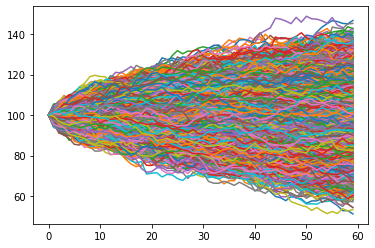

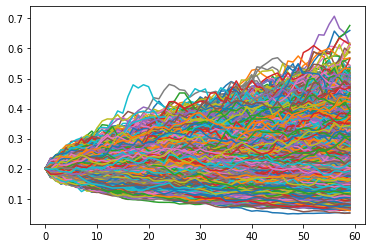

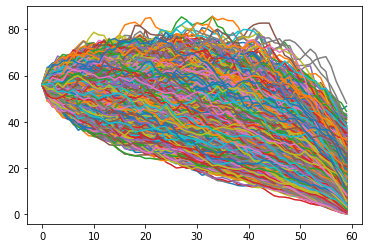

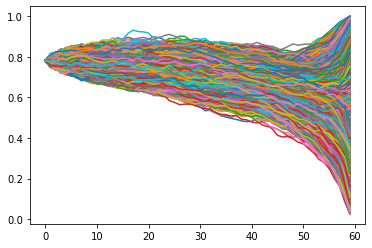

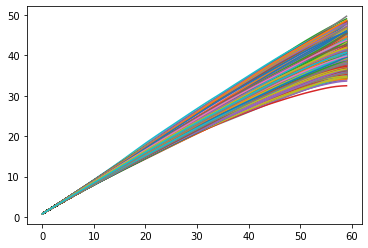

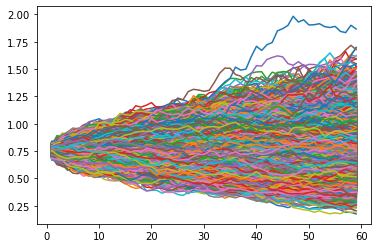

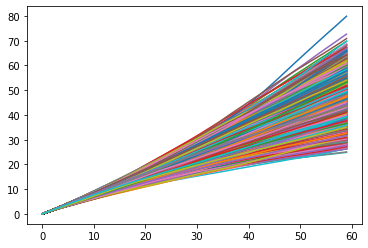

In [48]:
plt.plot(S.T)
plt.show()

plt.plot(stoch_vol.T) # ignore this (second) plot for GBM model, plotted only for debugging SABR
plt.show()

plt.plot(-p.T) # short call option price # use minus sign (-p) to get long call price
plt.show()

plt.plot(traded_bs.T)
plt.show()

plt.plot(holding_bs.T)
plt.show()

plt.plot(traded_bl.T)
plt.show()

plt.plot(holding_bl.T)
plt.show()

In [49]:
S.shape

(100000, 60)

In [51]:
# define data
# save to csv file
np.savetxt('asset_price_sim.csv', S, delimiter=',')
np.savetxt('option_price_sim.csv', p, delimiter=',')

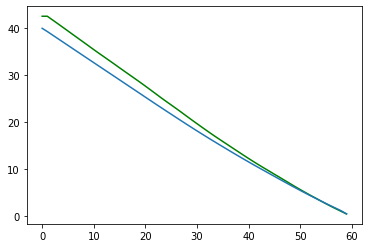

In [ ]:
C = hedgingCost(kappa, S, holding, holding_lag)
Y = objective(C, c)
plt.plot(C, c = 'g')
plt.plot(Y)
plt.show()


In [ ]:
# bartlett's delta hedging



## Evaluation

In [197]:
def APL_process(p, S, holding):
    '''
    Calculates the Accounting PnL process for a portfolio of an option, the underlying, with proportional trading costs
    Inputs:
        S =              [array] underlying price process
        p =              [array] option price process (adjusted for number of underlying)
        holding =        [array] process of number of the underlying held at each period
    Output:
        APL =            [array] process of Accounting PnL
        holding_lagged = [array] lagged process of number of underlying held at each period
    '''
    # create lagged variables for APL
    p_lagged = np.roll(p, 1)
    p_lagged[0] = np.nan # the first element was p[-1], this has to be changed to NaN
    S_lagged = np.roll(S, 1)
    S_lagged[0] = np.nan # the first element was S[-1], this has to be changed to NaN
    holding_lagged = np.roll(holding, 1)
    holding_lagged[0] = np.nan # the first element was holding[-1], this has to be changed to NaN
    


    # accounting PnL
    APL = p - p_lagged + holding_lagged*(S-S_lagged) - kappa* np.abs(S*(holding - holding_lagged)) 
    APL_unhedged = p-p_lagged

    return APL, holding_lagged, APL_unhedged

In [198]:
def hedgingCost(kappa, S, holding, holding_lagged):
    '''
    Calculates the total hedging cost from time t onward for all t
    Inputs:
        kappa =           [float] proportional hedging cost parameter
        S =               [array] underlying price process
        holding =         [array] process of amount of the underlying asset held at any given time t
        holding_lagged =  [array] process of amount of the underlying asset held at any given time t-1
    Output:
        C =               [array] total hedging cost from time t onward
    '''
    # Hedging cost at each period
    hedging_cost = kappa* np.abs(S*(holding - holding_lagged))

    # The reverse cumulative sum represents the remaining total hedging cost from time t onwards
    # The remaining total hedging cost C_t, is calculated at the beginning of each period t (before hedging transaction at time t is made)
    C = np.nancumsum(hedging_cost[::-1])[::-1] 

    return C

In [199]:
def objective(C, c):
    '''
    Calculates the loss from time t (present) to time T (expiry).
    Input:
        C = [array] total hedging cost, C[t] = total hedging cost from time t until T
        c = [float] weight of standard deviation
    Output:
        Y = [array] loss function over time, Y[t] = loss at time t
    '''
    Y = np.zeros(len(C))

    for t in range(len(C)):
        Y[t] = np.mean(C[t:]) + c*np.std(C[t:])

    return Y